# Laboratório Opcional: Avaliação e Seleção de Modelos

Quantificar o desempenho de um algoritmo de aprendizado e comparar diferentes modelos são algumas das tarefas comuns ao aplicar aprendizado de máquina a aplicativos do mundo real. Neste laboratório, você praticará isso usando as dicas compartilhadas em sala de aula. Especificamente, você irá:

* dividir conjuntos de dados em treinamento, validação cruzada e conjuntos de teste
* avaliar modelos de regressão e classificação
* adicionar recursos polinomiais para melhorar o desempenho de um modelo de regressão linear
* comparar várias arquiteturas de redes neurais

Este laboratório também ajudará você a se familiarizar com o código que verá na tarefa de programação desta semana. Vamos começar!

## Importações e configuração do laboratório

Primeiro, você importará os pacotes necessários para as tarefas deste laboratório. Também incluímos alguns comandos para tornar as saídas mais legíveis posteriormente, reduzindo a verbosidade e suprimindo avisos não críticos.

In [2]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# for building and training neural networks
import tensorflow as tf

# custom functions
import utils

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

## Regressão

Primeiro, você terá a tarefa de desenvolver um modelo para um problema de regressão. Você recebe o conjunto de dados abaixo que consiste em 50 exemplos de um recurso de entrada `x` e seu destino correspondente `y`.

In [3]:
# Load the dataset from the text file
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


Você pode plotar o conjunto de dados para ter uma ideia de como o destino se comporta em relação à entrada. Caso você queira inspecionar o código, você pode encontrar a função `plot_dataset()` no arquivo `utils.py` fora deste notebook.

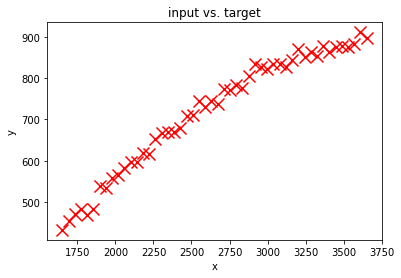

In [4]:
# Plot the entire dataset
utils.plot_dataset(x=x, y=y, title="input vs. target")

## Divida o conjunto de dados em conjuntos de treinamento, validação cruzada e teste

Em laboratórios anteriores, você pode ter usado todo o conjunto de dados para treinar seus modelos. Na prática, no entanto, é melhor manter uma parte de seus dados para medir o quão bem seu modelo generaliza para novos exemplos. Isso permitirá que você saiba se o modelo está superajustado ao seu conjunto de treinamento.

Conforme mencionado na palestra, é comum dividir seus dados em três partes:

* ***conjunto de treinamento*** - usado para treinar o modelo
* ***conjunto de validação cruzada (também chamado de validação, desenvolvimento ou conjunto de desenvolvimento)*** - usado para avaliar as diferentes configurações de modelo que você está escolhendo. Por exemplo, você pode usar isso para tomar uma decisão sobre quais recursos polinomiais adicionar ao seu conjunto de dados.
* ***conjunto de teste*** - usado para fornecer uma estimativa justa do desempenho do modelo escolhido em relação a novos exemplos. Isso não deve ser usado para tomar decisões enquanto você ainda está desenvolvendo os modelos.

O Scikit-learn fornece uma função [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) para dividir seus dados nas partes mencionadas acima. Na célula de código abaixo, você dividirá todo o conjunto de dados em 60% de treinamento, 20% de validação cruzada e 20% de teste.

In [5]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


Você pode plotar o conjunto de dados novamente abaixo para ver quais pontos foram usados como treinamento, validação cruzada ou dados de teste.

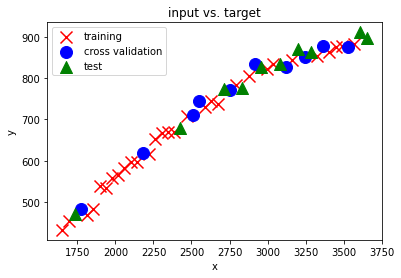

In [6]:
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

## Ajustar um modelo linear

Agora que você dividiu os dados, uma das primeiras coisas que você pode tentar é ajustar um modelo linear. Você fará isso nas próximas seções abaixo.

### Dimensionamento de recursos

No curso anterior desta especialização, você viu que geralmente é uma boa ideia realizar o dimensionamento de recursos para ajudar seu modelo a convergir mais rapidamente. Isso é especialmente verdadeiro se seus recursos de entrada tiverem faixas de valores muito diferentes. Posteriormente neste laboratório, você adicionará termos polinomiais para que seus recursos de entrada tenham intervalos diferentes. Por exemplo, $x$ vai de cerca de 1600 a 3600, enquanto $x^2$ vai de 2,56 milhões a 12,96 milhões.

Você usará apenas $x$ para este primeiro modelo, mas é bom praticar o dimensionamento de recursos agora para poder aplicá-lo mais tarde. Para isso, você usará a classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) do scikit-learn. Isso calcula o z-score de suas entradas. Para relembrar, o z-score é dado pela equação:

$$ z = \frac{x - \mu}{\sigma} $$

onde $\mu$ é a média dos valores dos recursos e $\sigma$ é o desvio padrão. O código abaixo mostra como preparar o conjunto de treinamento usando a referida classe. Você pode plotar os resultados novamente para inspecionar se ainda segue o mesmo padrão de antes. O novo gráfico deve ter uma faixa reduzida de valores para `x`.

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


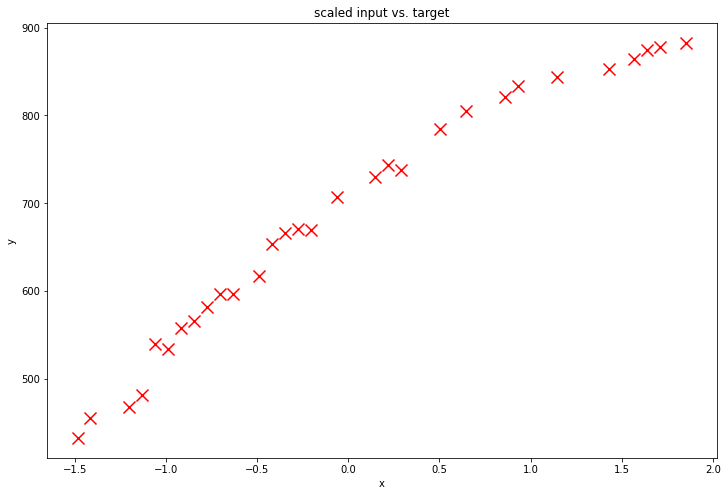

In [7]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

### Treine o modelo

Em seguida, você criará e treinará um modelo de regressão. Neste laboratório, você usará a classe [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), mas observe que existem outros [linear regressors](https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors) que você também pode usar.

In [8]:
# Initialize the class
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train_scaled, y_train )

LinearRegression()

### Avalie o modelo

Para avaliar o desempenho do seu modelo, convém medir o erro dos conjuntos de treinamento e validação cruzada. Para o erro de treinamento, lembre-se da equação para calcular o erro quadrático médio (MSE):

$$J_{trem}(\vec{w}, b) = \frac{1}{2m_{trem}}\left[\sum_{i=1}^{m_{trem}}(f_{\vec{ w},b}(\vec{x}_{trem}^{(i)}) - y_{trem}^{(i)})^2\right]$$

O Scikit-learn também possui uma função [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) integrada que você pode usar. Observe que [conforme a documentação](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), a implementação do scikit-learn divide apenas por `m` e não por `2 *m` (onde `m` = número de exemplos). Portanto, para corresponder à equação acima, você pode usar a função scikit-learn e dividir por dois, conforme mostrado abaixo. Também incluímos uma implementação for-loop para que você possa verificar se é igual.

Outra coisa a observar: como você treinou o modelo em valores dimensionados (ou seja, usando o z-score), você também deve alimentar o conjunto de treinamento dimensionado em vez de seus valores brutos.

In [9]:
# Feed the scaled training set and get the predictions
yhat = linear_model.predict(X_train_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

# for-loop implementation
total_squared_error = 0

for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i                                              

mse = total_squared_error / (2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

training MSE (using sklearn function): 406.19374192533155
training MSE (for-loop implementation): 406.19374192533155


Você pode calcular o MSE para o conjunto de validação cruzada com basicamente a mesma equação:

$$J_{cv}(\vec{w}, b) = \frac{1}{2m_{cv}}\left[\sum_{i=1}^{m_{cv}}(f_{\vec{ w},b}(\vec{x}_{cv}^{(i)}) - y_{cv}^{(i)})^2\right]$$

Assim como no conjunto de treinamento, você também desejará dimensionar o conjunto de validação cruzada. Uma coisa *importante* a observar ao usar o escore z é que você deve usar a média e o desvio padrão do **conjunto de treinamento** ao dimensionar o conjunto de validação cruzada. Isso é para garantir que seus recursos de entrada sejam transformados conforme esperado pelo modelo. Uma maneira de ganhar intuição é com este cenário:

* Digamos que seu conjunto de treinamento tenha um recurso de entrada igual a `500`, que é reduzido para `0,5` usando o z-score.
* Após o treinamento, seu modelo é capaz de mapear com precisão essa entrada dimensionada `x=0,5` para a saída de destino `y=300`.
* Agora, digamos que você implantou este modelo e um de seus usuários o alimentou com uma amostra igual a `500`.
* Se você obtiver o z-score desta amostra de entrada usando quaisquer outros valores de média e desvio padrão, ele pode não ser dimensionado para `0,5` e seu modelo provavelmente fará uma previsão errada (ou seja, diferente de `y = 300 `).

Você escalará o conjunto de validação cruzada abaixo usando o mesmo `StandardScaler` usado anteriormente, mas apenas chamando seu [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) em vez do método [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform).

In [10]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: 2504.06
Standard deviation used to scale the CV set: 574.85
Cross validation MSE: 551.7789026952216


## Adicionando recursos polinomiais

Nos gráficos anteriores, você deve ter notado que o alvo `y` aumenta mais acentuadamente em valores menores de `x` em comparação com os maiores. Uma linha reta pode não ser a melhor escolha porque o alvo `y` parece se nivelar à medida que `x` aumenta. Agora que você tem esses valores do MSE de treinamento e validação cruzada do modelo linear, pode tentar adicionar recursos polinomiais para ver se consegue um melhor desempenho. O código será basicamente o mesmo, mas com algumas etapas extras de pré-processamento. Vamos ver isso abaixo.

### Crie os recursos adicionais

Primeiro, você gerará os recursos polinomiais de seu conjunto de treinamento. O código abaixo demonstra como fazer isso usando a classe [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Ele criará um novo recurso de entrada que possui os valores quadrados da entrada `x` (ou seja, grau = 2).

In [11]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

# Preview the first 5 elements of the new training set. Left column is `x` and right column is `x^2`
# Note: The `e+<number>` in the output denotes how many places the decimal point should 
# be moved. For example, `3.24e+03` is equal to `3240`
print(X_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


Em seguida, você dimensionará as entradas como antes para restringir o intervalo de valores.

In [12]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements of the scaled training set.
print(X_train_mapped_scaled[:5])

[[ 1.43  1.47]
 [-0.28 -0.36]
 [ 1.71  1.84]
 [ 0.22  0.11]
 [ 0.15  0.04]]


Você pode prosseguir para treinar o modelo. Depois disso, você medirá o desempenho do modelo em relação ao conjunto de validação cruzada. Como antes, você deve certificar-se de realizar as mesmas transformações que fez no conjunto de treinamento. Você adicionará o mesmo número de recursos polinomiais e dimensionará o intervalo de valores.

In [13]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Training MSE: 49.111609334025154
Cross validation MSE: 87.6984121111191


Você notará que os MSEs são significativamente melhores para o conjunto de treinamento e validação cruzada quando você adicionou o polinômio de 2ª ordem. Você pode querer introduzir mais termos polinomiais e ver qual deles dá o melhor desempenho. Conforme mostrado na aula, você pode ter 10 modelos diferentes assim:

<img src='images/C2_W3_poly.png' width=50%>

Você pode criar um loop que contenha todas as etapas nas células de código anteriores. Aqui está uma implementação que adiciona recursos polinomiais até grau=10. Vamos plotá-lo no final para facilitar a comparação dos resultados de cada modelo.

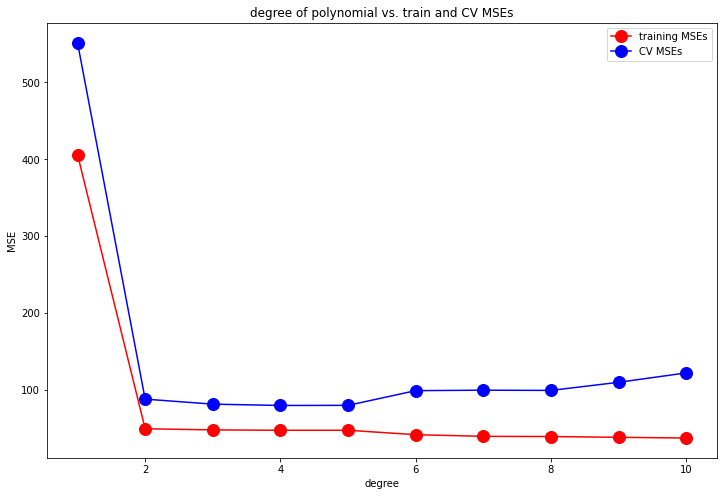

In [14]:
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

### Escolhendo o melhor modelo

Ao selecionar um modelo, você deseja escolher um que tenha um bom desempenho no conjunto de treinamento e validação cruzada. Isso implica que ele é capaz de aprender os padrões do seu conjunto de treinamento sem overfitting. Se você usou os padrões neste laboratório, notará uma queda acentuada no erro de validação cruzada dos modelos com grau=1 para grau=2. Isso é seguido por uma linha relativamente plana até grau = 5. Depois disso, no entanto, o erro de validação cruzada geralmente piora à medida que você adiciona mais recursos polinomiais. Diante disso, você pode decidir usar o modelo com o menor `cv_mse` como o mais adequado para sua aplicação.

In [15]:
# Get the model with the lowest CV MSE (add 1 because list indices start at 0)
# This also corresponds to the degree of the polynomial added
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=4


Você pode publicar o erro de generalização calculando o MSE do conjunto de teste. Como de costume, você deve transformar esses dados da mesma forma que fez com os conjuntos de treinamento e validação cruzada.

In [16]:
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


## Redes neurais

O mesmo processo de seleção de modelo também pode ser usado ao escolher entre diferentes arquiteturas de rede neural. Nesta seção, você criará os modelos mostrados abaixo e os aplicará à mesma tarefa de regressão acima.

<img src='images/C2_W3_NN_Arch.png' width=40%>

### Prepare os dados

Você usará os mesmos conjuntos de treinamento, validação cruzada e teste gerados na seção anterior. Nas aulas anteriores deste curso, você deve saber que as redes neurais podem aprender relacionamentos não lineares, então você pode optar por pular a adição de recursos polinomiais. O código ainda está incluído abaixo, caso você queira tentar mais tarde e ver o efeito que terá em seus resultados. O `degree` padrão é definido como `1` para indicar que ele usará apenas `x_train`, `x_cv` e `x_test` como está (ou seja, sem nenhum recurso polinomial adicional).

In [17]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

Em seguida, você escalará os recursos de entrada para ajudar a descida do gradiente a convergir mais rapidamente. Novamente, observe que você está usando a média e o desvio padrão calculados a partir do conjunto de treinamento usando apenas `transform()` na validação cruzada e nos conjuntos de teste em vez de `fit_transform()`.

In [18]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Construa e treine os modelos

Em seguida, você criará as arquiteturas de rede neural mostradas anteriormente. O código é fornecido na função `build_models()` no arquivo `utils.py` caso você queira inspecioná-lo ou modificá-lo. Você usará isso no loop abaixo e prosseguirá para treinar os modelos. Para cada modelo, você também registrará os erros de treinamento e validação cruzada.

In [19]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

# Build the models
nn_models = utils.build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

    
# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training model_1...
Done!

1/1 [==============================] - 0s 20ms/step
Training model_2...
Done!

1/1 [==============================] - 0s 19ms/step
Training model_3...
Done!

1/1 [==============================] - 0s 17ms/step
RESULTS:
Model 1: Training MSE: 73.40, CV MSE: 112.60
Model 2: Training MSE: 406.19, CV MSE: 551.78
Model 3: Training MSE: 42.40, CV MSE: 75.81


## Classificação

Nesta última parte do laboratório, você praticará a avaliação e seleção de modelos em uma tarefa de classificação. O processo será semelhante, com a principal diferença sendo o cálculo dos erros. Você verá isso nas seções a seguir.

### Carregar o conjunto de dados

Primeiro, você carregará um conjunto de dados para uma tarefa de classificação binária. Ele tem 200 exemplos de dois recursos de entrada (`x1` e `x2`) e um alvo `y` de `0` ou `1`.

In [20]:
# Load the dataset from a text file
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


Você pode plotar o conjunto de dados para examinar como os exemplos são separados.

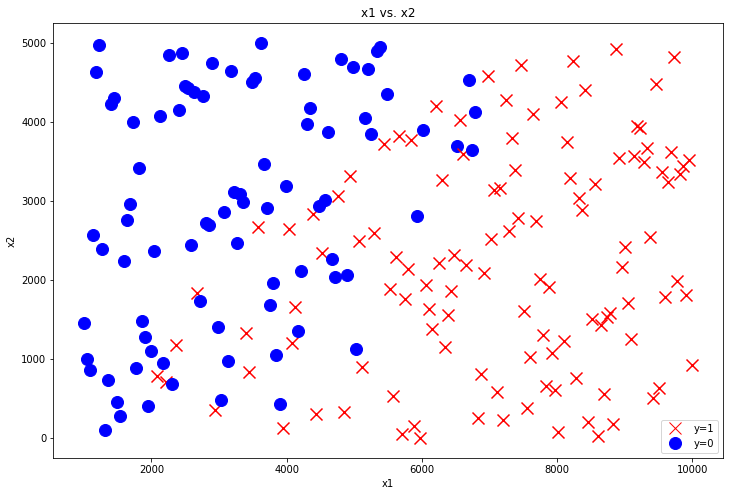

In [21]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

### Dividir o conjunto de dados

Em seguida, você gerará os conjuntos de treinamento, validação cruzada e teste. Você usará as mesmas proporções 60/20/20 de antes.

In [22]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


### Avaliando o erro para modelos de classificação

Nas seções anteriores sobre modelos de regressão, você usou o erro quadrático médio para medir o desempenho do seu modelo. Para classificação, você pode obter uma métrica semelhante obtendo a fração dos dados que o modelo classificou incorretamente. Por exemplo, se seu modelo fez previsões erradas para 2 amostras de 5, você relatará um erro de `40%` ou `0,4`. O código abaixo demonstra isso usando um loop for e também com a função [`mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) do Numpy.

In [23]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Crie e treine o modelo

Você usará as mesmas arquiteturas de rede neural na seção anterior para poder chamar a função `build_models()` novamente para criar novas instâncias desses modelos.

Você seguirá a abordagem recomendada mencionada na semana passada, onde você usa uma ativação `linear` para a camada de saída (em vez de `sigmoid`) e, em seguida, define `from_logits=True` ao declarar a função de perda do modelo. Você usará a [perda de crossentropy binário](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) porque este é um problema de classificação binária.

Após o treinamento, você usará uma [função sigmóide](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) para converter as saídas do modelo em probabilidades. A partir daí, você pode definir um limite e obter a fração de exemplos mal classificados dos conjuntos de treinamento e validação cruzada.

Você pode ver tudo isso na célula de código abaixo.

In [24]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = utils.build_models()

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

2/2 [==============================] - 0s 1000us/step
Training model_2...
Done!

2/2 [==============================] - 0s 3ms/step
Training model_3...
Done!

2/2 [==============================] - 0s 3ms/step
Model 1: Training Set Classification Error: 0.20833, CV Set Classification Error: 0.20000
Model 2: Training Set Classification Error: 0.14167, CV Set Classification Error: 0.10000
Model 3: Training Set Classification Error: 0.15000, CV Set Classification Error: 0.05000


Na saída acima, você pode escolher qual deles teve o melhor desempenho. Se houver um empate no erro do conjunto de validação cruzada, você pode escolher aquele com o menor erro do conjunto de treinamento. Por fim, você pode calcular o erro de teste para relatar o erro de generalização do modelo.

In [25]:
# Select the model with the lowest error
model_num = 2

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 [==============================] - 0s 3ms/step
Selected Model: 2
Training Set Classification Error: 0.1417
CV Set Classification Error: 0.1000
Test Set Classification Error: 0.1250


## Embrulhar

Neste laboratório, você praticou avaliar o desempenho de um modelo e escolher entre diferentes configurações de modelo. Você dividiu seus conjuntos de dados em conjuntos de treinamento, validação cruzada e teste e viu como cada um deles é usado em aplicativos de aprendizado de máquina. Na próxima seção do curso, você verá mais dicas sobre como melhorar seus modelos ao diagnosticar viés e variância. Mantem!